In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from hydra import compose, initialize
import matplotlib.pyplot as plt
import os
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from tqdm.auto import tqdm

from UniversalUnconsciousness.data_utils import *
from UniversalUnconsciousness.plot_utils import *

plt.style.use('UniversalUnconsciousness.sci_style')
load_font()

In [3]:
with initialize(version_base="1.3", config_path="../../UniversalUnconsciousness/DeLASE_analysis/conf"):
    cfg = compose(config_name="config")

In [ ]:
cfg.params.low_pass = None
cfg.params.high_pass = None
cfg.params.stride = 15

In [5]:
anesthetic_agent_list = cfg.plotting.anesthetic_agent_list
img_save_dir = cfg.plotting.img_save_dir
curve_colors = cfg.plotting.curve_colors
loc_roc_colors = cfg.plotting.loc_roc_colors
os.makedirs(img_save_dir, exist_ok=True)

In [6]:
verbose = False
agent_data = {}
# for data_class, agent in tqdm(anesthetic_agent_list):
for data_class, agent in [anesthetic_agent_list[2]]:
    if agent == 'propofol':
        cfg.params.grid_set = 'grid_set5'
    else:
        cfg.params.grid_set = 'grid_set4'

    cfg.params.data_class = data_class
    if 'propofol' in cfg.params.data_class:
        session_list = [f[:-4] for f in os.listdir(os.path.join(cfg.params.all_data_dir, 'anesthesia', 'mat', cfg.params.data_class)) if f.endswith('.mat')]
    else:
        session_list = [f[:-4] for f in os.listdir(os.path.join(cfg.params.all_data_dir, cfg.params.data_class, 'mat')) if f.endswith('.mat')]
        session_list = [session for session in session_list if session not in ['PEDRI_Ketamine_20220203']]
        bad_session_list = ['PEDRI_Ketamine_20220113', 'PEDRI_Ketamine_20220126', 'PEDRI_Ketamine_20220203', 'PEDRI_Ketamine_20220222', 'SPOCK_Ketamine_20210722', 'SPOCK_Ketamine_20210730']
        session_list = [session for session in session_list if session not in bad_session_list]
        session_list = [session for session in session_list if agent.lower()[:3] in session.lower()]
    
    areas = ['all']
    agent_data[(data_class, agent)] = {'session_list': session_list}

    session_lists, locs, rocs, ropaps = get_session_plot_info(cfg, session_list, verbose=False)

    agent_data[(data_class, agent)]['session_lists'] = session_lists
    agent_data[(data_class, agent)]['locs'] = locs
    agent_data[(data_class, agent)]['rocs'] = rocs
    agent_data[(data_class, agent)]['ropaps'] = ropaps

    noise_filter_info = get_noise_filter_info(cfg, session_list, verbose=verbose)
    agent_data[(data_class, agent)]['noise_filter_info'] = noise_filter_info
    
    pca_chosen = get_pca_chosen(cfg, session_list, areas, noise_filter_info, verbose=verbose)
    agent_data[(data_class, agent)]['pca_chosen'] = pca_chosen
    all_indices_to_run = collect_grid_indices_to_run(cfg, session_list, areas, noise_filter_info, pca_chosen, verbose=verbose)
    if all_indices_to_run:
        raise ValueError(f"Sessions for agent {agent} have incomplete grid search - cannot continue")
    
    raise ValueError('stop here')

Only 3 valid windows could be found for section 'early unconscious' with times [np.float64(26.003301111111107), 45]
Only 1 valid windows could be found for section 'awake lever1' with times [np.float64(-36.120676111111116), np.float64(-26.045618333333337)]
Only 3 valid windows could be found for section 'awake lever1' with times [np.float64(-36.10079944444445), np.float64(-26.03974944444445)]
Only 0 valid windows could be found for section 'awake lever2' with times [np.float64(-10.029036111111115), 0]


ValueError: stop here

In [34]:
session = session_list[0]

In [35]:
section_info, _, _, _ = get_section_info(session, cfg.params.all_data_dir, cfg.params.data_class)
grid_search_results = get_grid_search_results(cfg, session_list, areas, len(section_info), pca_chosen, verbose=verbose)

In [36]:
session

'SPOCK_Dexmedetomidine_20211028'

In [41]:
mean_mase = grid_search_results[session]['all']['mats']['mase'].mean(axis=0)
mean_aic = grid_search_results[session]['all']['mats']['aic'].mean(axis=0)

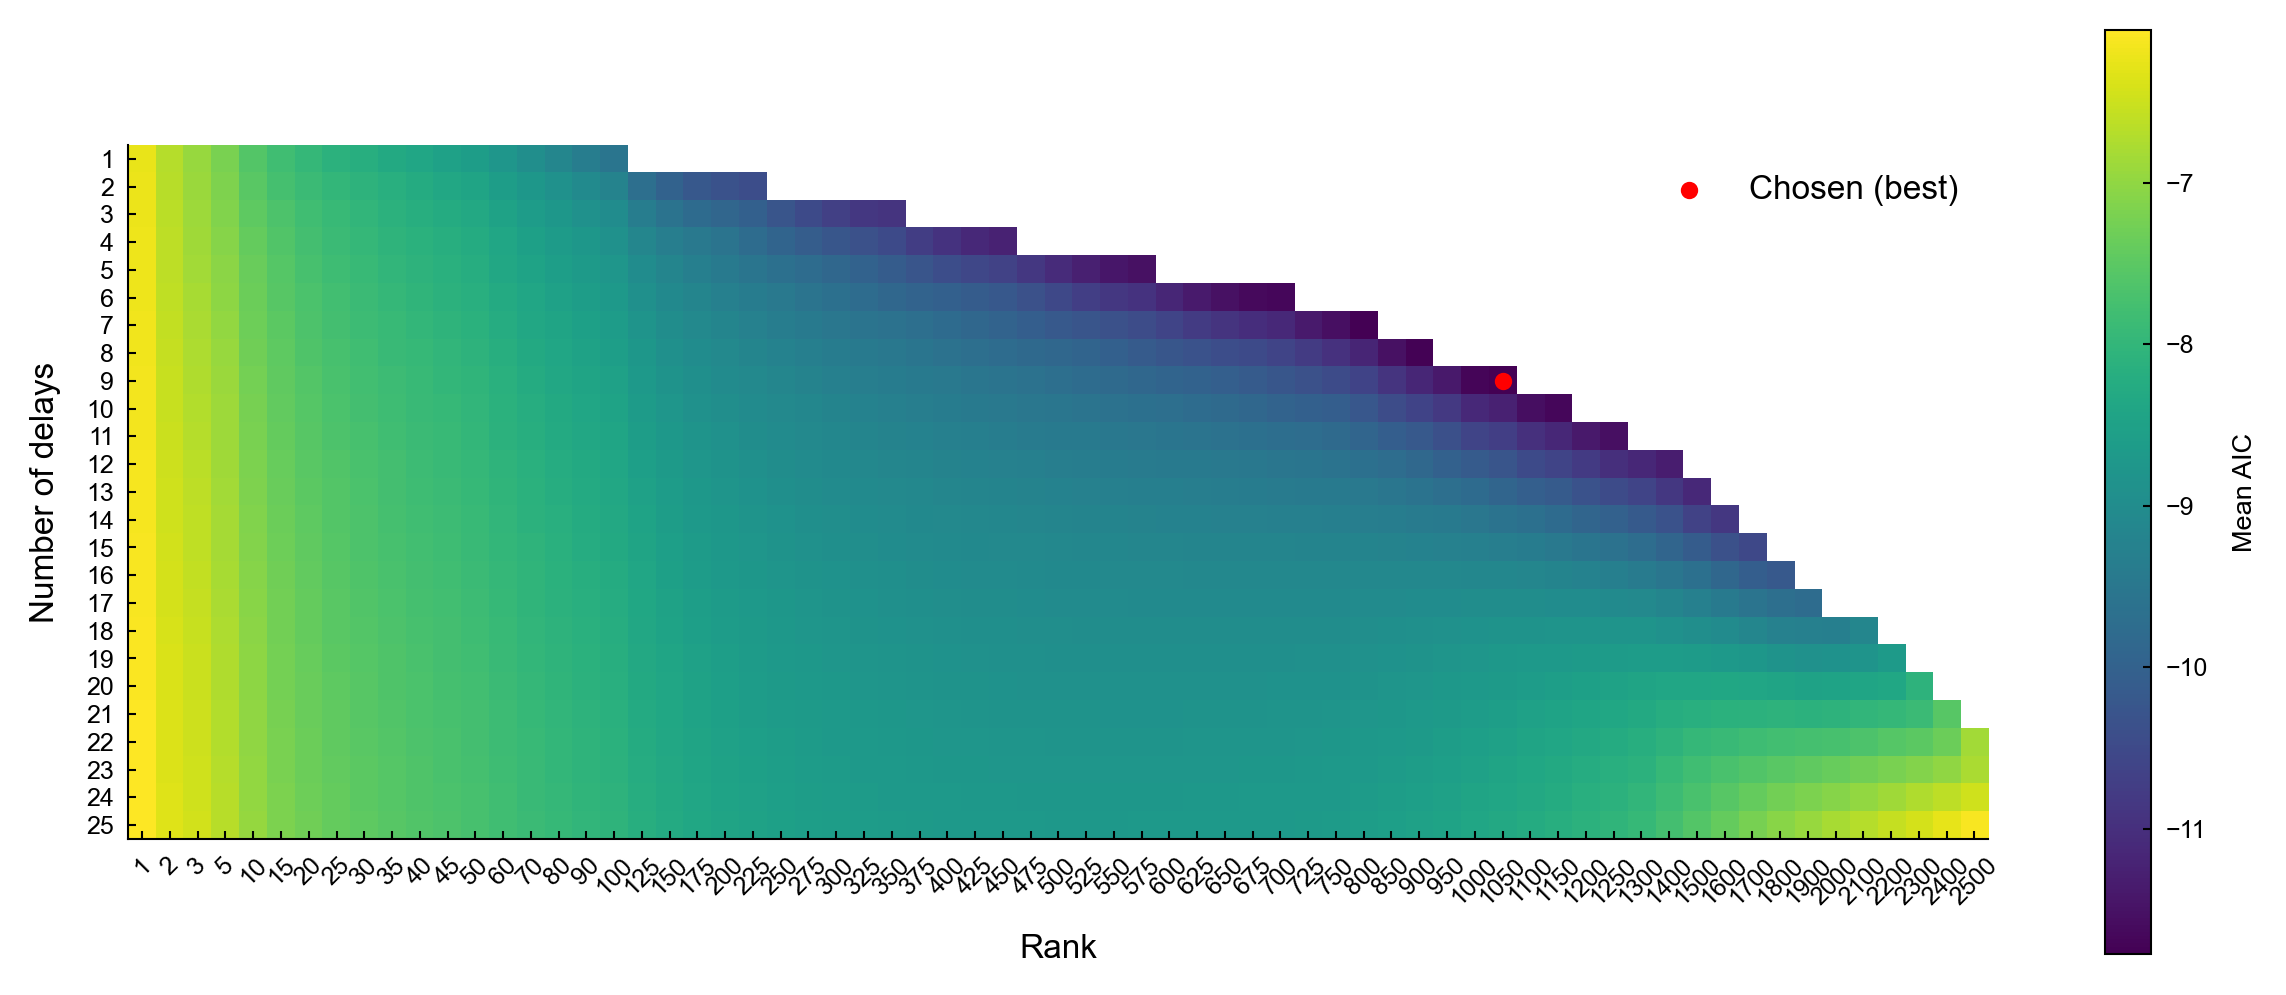

In [44]:
rank_vals = cfg.grid_sets.grid_set4.rank_vals
n_delays_vals = cfg.grid_sets.grid_set4.n_delays_vals

n_delays_chosen, rank_chosen = grid_search_results[session_list[0]]['all']['n_delays'], grid_search_results[session_list[0]]['all']['rank']

plt.figure(figsize=(10, 4))
plt.imshow(mean_aic)
# make xticks the ranks
plt.xticks(np.arange(len(rank_vals)), rank_vals, fontsize=6)
# rotate xticks
plt.xticks(rotation=45)
plt.xlabel('Rank', fontsize=8)
# make yticks the n_delays values
plt.yticks(np.arange(len(n_delays_vals)), n_delays_vals, fontsize=6)
plt.ylabel('Number of delays', fontsize=8)
plt.colorbar(label='Mean AIC')
# scatter the chosen (best) point
plt.scatter(rank_vals.index(rank_chosen), n_delays_vals.index(n_delays_chosen), color='red', s=10, marker='o', label='Chosen (best)')
# add a legend
plt.legend(fontsize=8)
plt.savefig(
        os.path.join(cfg.plotting.img_save_dir, 'supp',
                     f'{session}_grid_results.pdf'),
        bbox_inches='tight', transparent=True
    )
plt.show()